# Mississipi Flood Mechanisms 
This program processes the following data from the NOAA-NCAR 20th century reanalysis V3 dataset

- soilm
- uwnd
- vwnd
- hgt 

To run: download all files from https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.html and place in one folder and change "data_dir" variable to point to it. Also change "riv_path" to point to "data" folder in this repo

All computations analyze atmospheric/soil conditions 3 months leading up floods of note on the Mississippi, Missouri, and Ohio Rivers. 
Analyses are as follows 

- compute standardized value of 
- for each location of interest and for every one of the top 15 flood events at that location, compute the average standardized and raw values
- bootstrap a measure of confidence 
- print all results to .csv files for GIS plotting 

## Data Wrangling
### File locations and import packages

In [1]:
#local data paths 
riv_path = r'D:\Data\river data\USGS\top_ten_2022.csv' 
data_dir = r'D:\bootstrap'
write_location= r'C:\Users\bydd1\Downloads'

In [2]:
#import packages
import pandas as pd
import vis_methods as vm 
import env_methods as em
from netCDF4 import Dataset
import os 
import time as pytime
from copy import deepcopy
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import numpy as np 
import random 

### Acquire data

In [3]:
riv_dates = pd.read_csv(riv_path)
#riv_dates = riv_dates.drop(columns = 'vicksburg')
data_package = em.get_data(data_dir, False, [1,1948,1,2020])

['level', 'lat', 'lon', 'time', 'nbnds']
acquring data from hgt.mon.mean.nc
acquring data from soilm.mon.mean.nc
acquring data from uwnd.mon.mean.nc
acquring data from vwnd.mon.mean.nc


In [4]:
#make all data 3d 
list_keys = list(data_package['nc_vars'].keys())
for k in list_keys:
    d = data_package['nc_vars'][k]
    if len(np.shape(d)) == 4:
        data_package['nc_vars'][k + "_1000"] = data_package['nc_vars'][k][:,0,:,:]
        data_package['nc_vars'][k + "_850"] = data_package['nc_vars'][k][:, 1, :, :]
        data_package['nc_vars'].pop(k)

### Get Dimensions

In [5]:
lat = data_package['lat']
lon = data_package['lon']
time = data_package['time']
pres = data_package['level']

### Find index of flood dates within NCEP-NCAR time 

In [6]:
riv_dates

,hermann,louisville,vicksburg
0,7/1/1993,3/1/1964,5/1/2011
1,7/1/1951,3/1/2021,5/1/1973
2,5/1/1995,3/1/1997,1/1/2016
3,10/1/1986,2/1/2018,2/1/1950
4,5/1/2017,3/1/2015,3/1/2019
5,4/1/1973,4/1/1948,4/1/1975
6,12/1/2015,2/1/2019,4/1/2008
7,6/1/2013,4/1/2011,3/1/2018
8,4/1/1994,3/1/1967,5/1/1983
9,2/1/1985,12/1/1978,3/1/1997


In [7]:
riv_time_ind = pd.DataFrame()
for loc in riv_dates.columns.tolist():
    riv_dates[loc] = pd.to_datetime(riv_dates[loc], format = "%m/%d/%Y") #convert to dt object
    loc_ind = []
    
    for event in riv_dates[loc]:
        ind = em.find_closest_val(event, time)
        loc_ind.append(ind)
        
        #also append 3 prior months of data 
        loc_ind.append(ind - 1)
        loc_ind.append(ind - 2)
        loc_ind.append(ind - 3)
        
    riv_time_ind[loc] = loc_ind
    

### Cut the data by lat/lon bounding box 

In [8]:
bbox = {'lat' : [-20, 60],
        'lon' : [360-170, 360-10]}

print(bbox)
bbox_c = {'lat': [em.find_closest_val(l, lat) for l in bbox['lat']],
         'lon': [em.find_closest_val(l, lon) for l in bbox['lon']]}
print(bbox_c)

{'lat': [-20, 60], 'lon': [190, 350]}
{'lat': [70, 150], 'lon': [190, 350]}


In [9]:
lat = lat[bbox_c['lat'][0]:bbox_c['lat'][1]]
lon = lon[bbox_c['lon'][0]:bbox_c['lon'][1]]

In [10]:
keys = data_package['nc_vars'].keys()
mv = np.nanmin(data_package['nc_vars']['soilm'])
for k in keys:
    d = deepcopy(data_package['nc_vars'][k])
    if len(np.shape(d)) == 3:
        d =  np.asarray(d[:, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
    else:
        d = np.asarray(d[:, :, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
    d[d == mv] = np.nan
    data_package['nc_vars'][k] = d

### Compute anomaly 

In [11]:
for k in list(keys):
    print(k)
    d = deepcopy(data_package['nc_vars'][k])
    if len(np.shape(d)) == 3:
        d[np.isnan(d)] = 0
        d = em.normalize_data(d, time)
    elif len(np.shape(d)) == 4:
        d[np.isnan(d)] = 0
        for p in range(0, len(pres)):
            d[:, p, :, :] = em.normalize_data(d[:, p, :, :], time)
    d[d == 0 ] = np.nan
    d[d == 0.0] = np.nan
    data_package['nc_vars'][k + '_stand'] = d

soilm


C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\env_methods.py:135: RuntimeWarning: invalid value encountered in true_divide
  stdev_monthly[month - 1])


hgt_1000
hgt_850
uwnd_1000
uwnd_850
vwnd_1000
vwnd_850


### Bootstrap expected value for each percentile 
Note 
- 90th percentile: 1.282
- 95th percentile: 1.645
- 99th percentile: 2.326

In [12]:
#bootstrap analysis of 3D data field d with dimensions (time x lat x lon)
#compute the average of `num_samples` (int) random timesteps within d 
def bootstrap(dataset, num_samples, num_iter):
    fillme = np.zeros((num_iter, np.shape(dataset)[1], np.shape(dataset)[2])) #initialize empty array 
    t_index = np.arange(0, np.shape(dataset)[0]) #range of time index values 
    for i in range(0, num_iter): #iterate some large number of times 
        inds = [random.choice(t_index) for j in range(0, num_samples)] #randomly select num_samples number of dates 
        #make array with 3 consecutive months before flood date 
        new_inds = []
        for j in inds:
            for k in [0,1,2,3]: #collect 3 months before each random date 
                new_inds.append(j - k)   
        #compute mean of filled array 
        fillme[i, :, :] = (np.nanmean(dataset[new_inds, :, :], axis = 0))
    mean = np.nanmean(fillme, axis = 0)
    std = np.nanstd(fillme, axis = 0)
    #percentiles of interest 
    ninetieth = mean + std * 1.282
    ninetyfifth = mean + std * 1.645
    ninetyninth = mean + std * 2.326
    tenth = mean - std * 1.282
    fifth = mean - std * 1.645
    one = mean - std * 2.326
    return ninetieth, ninetyfifth, ninetyninth, tenth, fifth, one

### Check bootstrap method 

min =  -191.86911
max =  288.56894
mean =  119.47245
std =  39.492496


<Figure size 432x288 with 0 Axes>

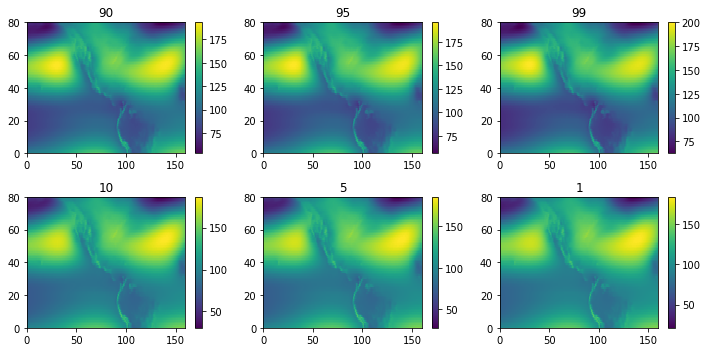

In [13]:
print("min = ", np.min(data_package['nc_vars']['hgt_1000']))
print("max = ", np.max(data_package['nc_vars']['hgt_1000']))
print("mean = ", np.mean(data_package['nc_vars']['hgt_1000']))
print("std = ", np.std(data_package['nc_vars']['hgt_1000']))

vals = bootstrap(data_package['nc_vars']['hgt_1000'], len(riv_dates), 10)
plt.figure()
names = ['90','95','99','10','5','1']
plt.figure(figsize = (10,5))
for i in np.arange(0,6):
    plt.subplot(2,3,i+1)
    mesh = plt.pcolormesh(vals[i])
    plt.colorbar(mesh)
    plt.title(names[i])
plt.tight_layout()


In [14]:
#compute bootstrap for every field (including standardized)
names = ['90','95','99','10','5','1']
for k in list(keys):
    print(k)
    d = deepcopy(data_package['nc_vars'][k])
    vals = bootstrap(d, len(riv_dates),10)
    for v in range(0, len(vals)):
        data_package['nc_vars'][k + '_bootstrap' + names[v]] = vals[v]        

soilm
hgt_1000
hgt_850


C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\bydd1\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


uwnd_1000
uwnd_850
vwnd_1000
vwnd_850
soilm_stand
hgt_1000_stand
hgt_850_stand
uwnd_1000_stand
uwnd_850_stand
vwnd_1000_stand
vwnd_850_stand


### Write variables to file 
- raw and standardized value for EACH DATA FIELD + LOCATION 
- bootstrapped values for each DATA FIELD (will be same at each location, but we'll put it in each file) 

To make it easy to put in GIS, we want to column-ize our 2d data-arrays.

In [15]:
os.chdir(write_location)
c1 = ['lat', 'lon', 'hgt_850', 'hgt_1000', 'soilm', 'uwnd_850', 'uwnd_1000', 'vwnd_850', 'vwnd_1000']
c = list(data_package['nc_vars'].keys())
c.append('lat')
c.append('lon')
for loc in riv_time_ind:  #iterate through locations 
    frame = {} #this is the frame we want to write as a csv 
    for n in c: #initialize every feild of interest with empty array to append to 
        frame[n] = []
    
    #now create a temp dictionary with 2d arrays for each location 
    temp_dict = {}
    for n in c1[2:len(c)]: #iterate through all keys and assign varaibles as needed 
        #for the raw and standardized datasets, we need to do a temporal average of all flood date indices 
        temp_dict[n] = np.nanmean(data_package['nc_vars'][n][riv_time_ind[loc], :, :], axis = 0)
        temp_dict[n + "_stand"] = np.nanmean(data_package['nc_vars'][n + "_stand"][riv_time_ind[loc], :, :], axis = 0)
    for n in c:
        if n not in c1 and n[-5:] != 'stand': #if its not a raw or standardized value, just pull the field from data_package 
            temp_dict[n] = data_package['nc_vars'][n]
    
    #iterate through all lats/ lons and assign vals 
    for i in range(len(lat)):
        for j in range(len(lon)):
            frame['lat'].append(lat[i])
            frame['lon'].append(lon[j])
            for n in temp_dict.keys():
                frame[n].append(temp_dict[n][i,j])

    frame = pd.DataFrame(frame)   
    frame.fillna(-9999)
    frame.to_csv(loc + '_feb22.csv')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


### Read back in from csv to make sure we got it right

In [16]:
### testing! 
hermann = pd.read_csv('hermann_feb22.csv')
louisville = pd.read_csv('louisville_feb22.csv')

for f in ['h', 'l']:
    dic ={}
    if f == 'h':
        file = hermann
    if f == 'l':
        file = louisville
    for v in file: 
        if v not in ['Unnamed: 0', 'lat', 'lon']:
            array = np.zeros((len(lat), len(lon)))
            
            for k in range(len(file)):
                lat_ = file['lat'][k]
                lon_ = file['lon'][k]
                lat_i = lat.index(lat_)
                lon_i = lon.index(lon_)

                array[lat_i, lon_i] = file[v][k]
                array[array == -9999] = np.nan
            dic[v] = array
            
    if f == 'h': hermann_dic = deepcopy(dic)
    if f == 'l': louisville_dic = deepcopy(dic)


In [17]:
hermann_dic.keys()

dict_keys(['soilm', 'hgt_1000', 'hgt_850', 'uwnd_1000', 'uwnd_850', 'vwnd_1000', 'vwnd_850', 'soilm_stand', 'hgt_1000_stand', 'hgt_850_stand', 'uwnd_1000_stand', 'uwnd_850_stand', 'vwnd_1000_stand', 'vwnd_850_stand', 'soilm_bootstrap90', 'soilm_bootstrap95', 'soilm_bootstrap99', 'soilm_bootstrap10', 'soilm_bootstrap5', 'soilm_bootstrap1', 'hgt_1000_bootstrap90', 'hgt_1000_bootstrap95', 'hgt_1000_bootstrap99', 'hgt_1000_bootstrap10', 'hgt_1000_bootstrap5', 'hgt_1000_bootstrap1', 'hgt_850_bootstrap90', 'hgt_850_bootstrap95', 'hgt_850_bootstrap99', 'hgt_850_bootstrap10', 'hgt_850_bootstrap5', 'hgt_850_bootstrap1', 'uwnd_1000_bootstrap90', 'uwnd_1000_bootstrap95', 'uwnd_1000_bootstrap99', 'uwnd_1000_bootstrap10', 'uwnd_1000_bootstrap5', 'uwnd_1000_bootstrap1', 'uwnd_850_bootstrap90', 'uwnd_850_bootstrap95', 'uwnd_850_bootstrap99', 'uwnd_850_bootstrap10', 'uwnd_850_bootstrap5', 'uwnd_850_bootstrap1', 'vwnd_1000_bootstrap90', 'vwnd_1000_bootstrap95', 'vwnd_1000_bootstrap99', 'vwnd_1000_boots

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


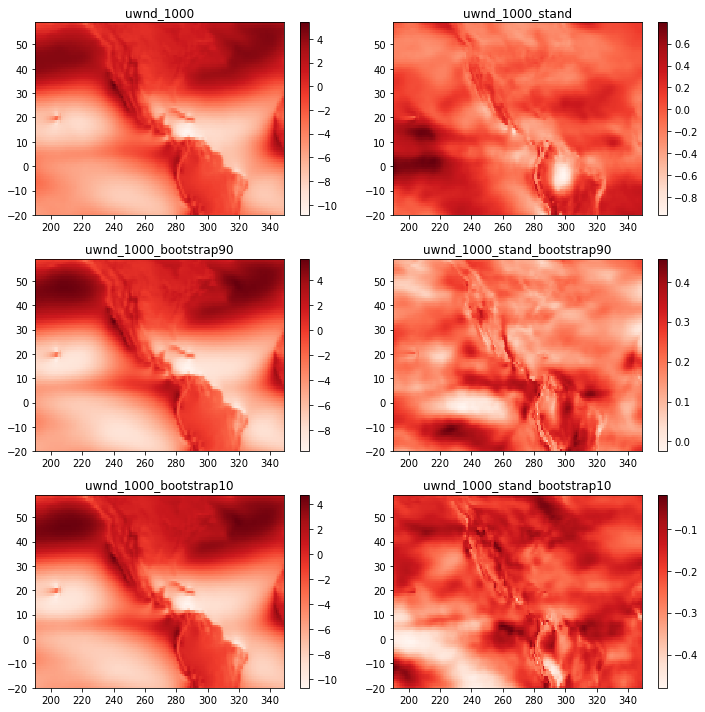

In [47]:
d = hermann_dic
v = 'uwnd_1000'
variations = ['', '_stand', '_bootstrap90', '_stand_bootstrap90', '_bootstrap10', '_stand_bootstrap10']
plt.figure(figsize = (10,10))
for i in range(0,len(variations)):
    ax = plt.subplot(3,2,i+1)
    mesh = plt.pcolormesh(lon, lat, d[v + variations[i]], cmap = 'Reds')
    plt.title(v + variations[i])
    plt.colorbar(mesh)
plt.tight_layout()
plt.savefig(write_location + '\hgt_1000.png')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


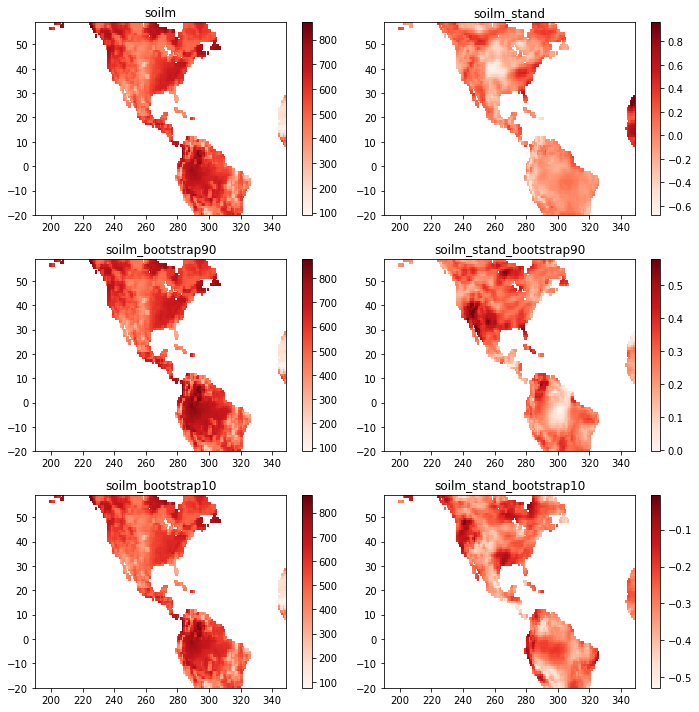

In [19]:
d = louisville_dic
v = 'soilm'
variations = ['', '_stand', '_bootstrap90', '_stand_bootstrap90', '_bootstrap10', '_stand_bootstrap10']
plt.figure(figsize = (10,10))
for i in range(0,len(variations)):
    ax = plt.subplot(3,2,i+1)
    mesh = plt.pcolormesh(lon, lat, d[v + variations[i]], cmap = 'Reds')
    plt.title(v + variations[i])
    plt.colorbar(mesh)
plt.tight_layout()
plt.savefig(write_location + '\hgt_1000.png')

### Check our results for significance 

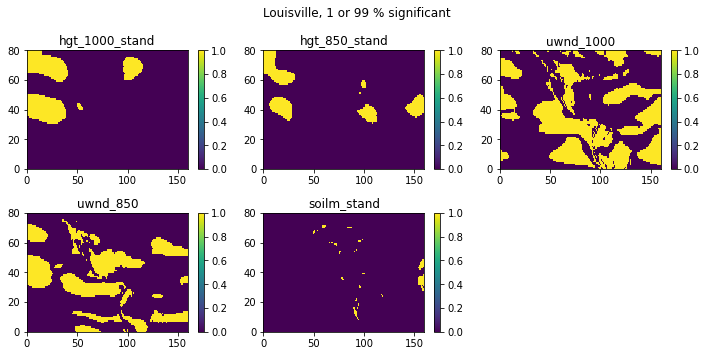

In [65]:
d = louisville_dic 
variables = ['hgt_1000_stand', 'hgt_850_stand', 'uwnd_1000', 'uwnd_850', 'soilm_stand']
bootstrap_levelhigh = "_bootstrap99"
bootstrap_levellow = "_bootstrap1"
plt.figure(figsize = (10,5))
for v in range(0, len(variables)):
    plt.subplot(2,3,v+1)
    boolean1 = d[variables[v]] > d[variables[v]+bootstrap_levelhigh]
    boolean2 = d[variables[v]] < d[variables[v]+bootstrap_levellow]
    boolean = boolean1 + boolean2
    mesh = plt.pcolormesh(boolean)
    plt.colorbar(mesh)
    plt.title(variables[v])
plt.suptitle("Louisville, <1% or >99 % significant")
plt.tight_layout()

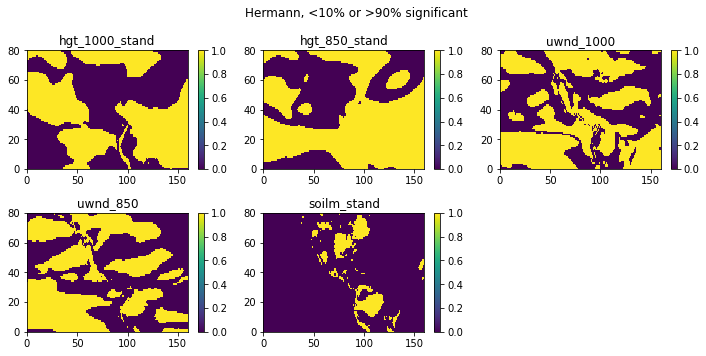

In [67]:
d = hermann_dic 
variables = ['hgt_1000_stand', 'hgt_850_stand', 'uwnd_1000', 'uwnd_850', 'soilm_stand']
bootstrap_levelhigh = "_bootstrap90"
bootstrap_levellow = "_bootstrap10"
plt.figure(figsize = (10,5))
for v in range(0, len(variables)):
    plt.subplot(2,3,v+1)
    boolean1 = d[variables[v]] > d[variables[v]+bootstrap_levelhigh]
    boolean2 = d[variables[v]] < d[variables[v]+bootstrap_levellow]
    boolean = boolean1 + boolean2
    mesh = plt.pcolormesh(boolean)
    plt.colorbar(mesh)
    plt.title(variables[v])
plt.suptitle("Hermann, <10% or >90% significant")
plt.tight_layout()
